# Synthetic YOLO Training Notebook

This notebook automates a YOLOv8 training workflow using your `yolo_synthetic_dataset`. Edit `CONFIG` cell before training.

In [50]:
DATASET_ROOT = 'datasets/yolo_synthetic_dataset'
DATA_YAML = f"{DATASET_ROOT}/yolo_synthetic_dataset.yaml"
NUM_EPOCHS = 20
MODEL = 'yolov8n.pt'
BATCH = 16
IMG_SIZE = 512
DEVICE = 'cpu'
DO_TRAIN = True


In [55]:
!pip install -q --upgrade pip
!pip install -q ultralytics
import ultralytics, torch
print('ultralytics', ultralytics.__version__)
print('torch', torch.__version__)
!pip install plotly --quiet
import plotly.graph_objects as go
import pandas as pd
from pathlib import Path



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
D:\ThisPC\Documents\Unity Projects\synthetic-vision-training-pipeline\.venv\Scripts\python.exe -m pip install -q --upgrade pip


ultralytics 8.3.232
torch 2.9.1+cpu



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


DATASET_ROOT: D:\ThisPC\Documents\Unity Projects\synthetic-vision-training-pipeline\2. python_scripts\src\datasets\yolo_synthetic_dataset
images/train exists: True
images found: 450


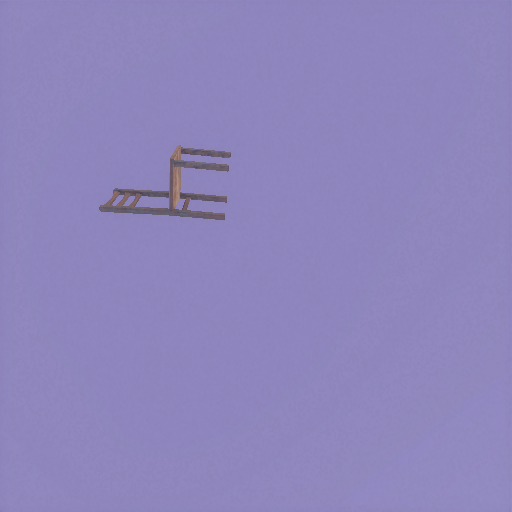

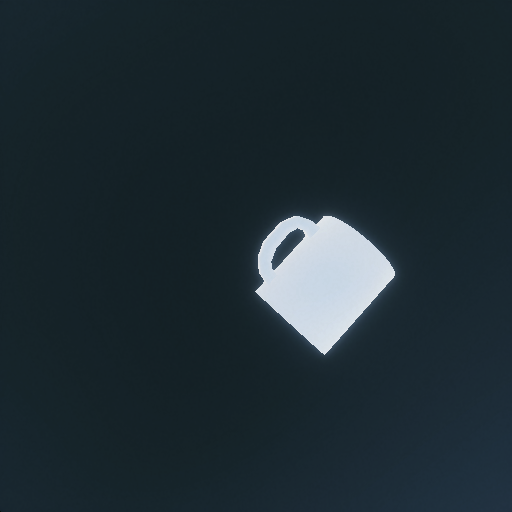

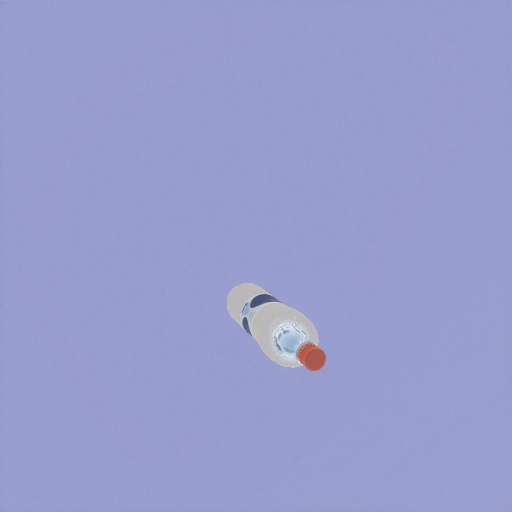

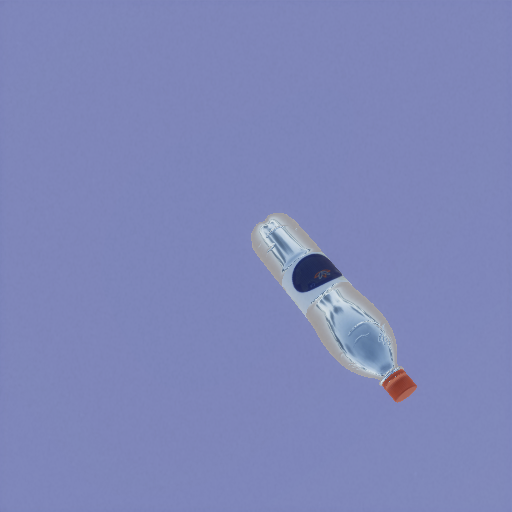

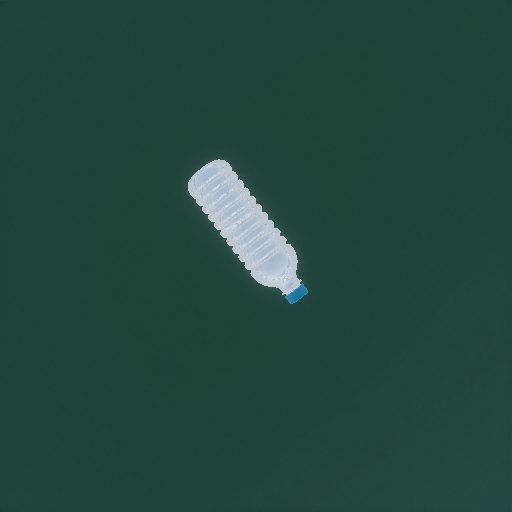

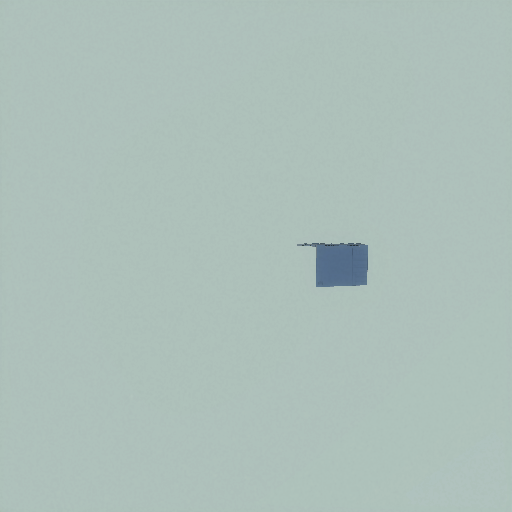

In [56]:
# FINAL minimal dataset sanity-check (ONLY THIS ONE)

from pathlib import Path
from PIL import Image, ImageDraw
from IPython.display import display
import random, os

# --- fix accidental src/src once ---
root = Path(DATASET_ROOT)
root = Path(str(root).replace(f"{os.sep}src{os.sep}src{os.sep}", f"{os.sep}src{os.sep}")).resolve()

print("DATASET_ROOT:", root)
if not root.exists():
    raise FileNotFoundError(root)

images_dir = root / "images" / "train"
labels_dir = root / "labels" / "train"
print("images/train exists:", images_dir.exists())

if not images_dir.exists():
    raise FileNotFoundError(images_dir)

# --- collect images ---
exts = {".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp"}
imgs = [p for p in images_dir.glob("*") if p.suffix.lower() in exts]
if not imgs:
    imgs = [p for p in images_dir.rglob("*") if p.suffix.lower() in exts]
if not imgs:
    raise RuntimeError("No images found")

print("images found:", len(imgs))

# --- show samples with YOLO boxes ---
for img_path in random.sample(imgs, min(6, len(imgs))):
    im = Image.open(img_path).convert("RGB")
    w,h = im.size
    draw = ImageDraw.Draw(im)

    label = labels_dir / f"{img_path.stem}.txt"
    if label.exists():
        for ln in label.read_text().split():
            parts = ln.split()
            if len(parts) < 5: continue
            cid,x,y,bw,bh = int(float(parts[0])), *map(float, parts[1:5])
            left  = (x - bw/2)*w
            top   = (y - bh/2)*h
            right = (x + bw/2)*w
            bottom= (y + bh/2)*h
            draw.rectangle([left, top, right, bottom], outline="red", width=2)
            draw.text((left, max(0, top-12)), str(cid))

    display(im)


In [57]:
from ultralytics import YOLO

if DO_TRAIN:
    model = YOLO(MODEL)
    print("Training started on CPU...")

    results = model.train(
        data=DATA_YAML,
        epochs=NUM_EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH,
        device="cpu",
        project="runs/detect",
        name="synth_run"
    )

    print("Training complete.")

    # === PLOTLY CHARTS (safe, no recursion) ===
    csv_path = Path("runs/detect/synth_run/results.csv")
    if csv_path.exists():
        df = pd.read_csv(csv_path)

        fig = go.Figure()

        # Add major metrics
        fig.add_trace(go.Scatter(y=df['box_loss'], mode="lines", name="box_loss"))
        fig.add_trace(go.Scatter(y=df['cls_loss'], mode="lines", name="cls_loss"))
        fig.add_trace(go.Scatter(y=df['dfl_loss'], mode="lines", name="dfl_loss"))
        fig.add_trace(go.Scatter(y=df['metrics/mAP50'], mode="lines", name="mAP50"))
        fig.add_trace(go.Scatter(y=df['metrics/mAP50-95'], mode="lines", name="mAP50-95"))

        fig.update_layout(
            title="YOLO Synthetic Training Metrics",
            xaxis_title="Epoch",
            yaxis_title="Value",
            template="plotly_dark",
            height=500,
        )

        fig.show()
    else:
        print("WARNING: results.csv not found. Cannot draw chart.")

else:
    print("DO_TRAIN is False - skipping actual train")


Training started on CPU...
Ultralytics 8.3.232  Python-3.14.0 torch-2.9.1+cpu CPU (12th Gen Intel Core i3-12100)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/yolo_synthetic_dataset/yolo_synthetic_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=synth_run4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ove

RecursionError: maximum recursion depth exceeded

In [58]:
# Jupyter cell: plot_hardcoded_yolo_run.ipynb (single cell)
# Paste and run this in a notebook cell. Uses Plotly (will auto-install if missing).

from __future__ import annotations
from pathlib import Path
import sys

# ---- install runtime deps if missing ----
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd
except Exception:
    import os
    print("Installing plotly + pandas...")
    os.system(f"{sys.executable} -m pip install plotly pandas --quiet")
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd

# ---- hardcoded metrics extracted from your training log (20 epochs) ----
epochs = list(range(1, 21))

box_loss = [0.6699, 0.6802, 0.7015, 0.7455, 0.7382, 0.7013, 0.6781, 0.6342, 0.6622, 0.6263,
            0.4102, 0.3800, 0.3536, 0.3609, 0.3311, 0.3073, 0.2943, 0.2838, 0.2683, 0.2491]
cls_loss = [3.086, 2.315, 2.097, 1.925, 1.751, 1.557, 1.513, 1.396, 1.325, 1.225,
            1.210, 1.014, 0.9668, 0.8737, 0.8538, 0.8312, 0.7736, 0.7346, 0.6861, 0.6519]
dfl_loss = [0.9552, 0.9608, 0.9939, 1.019, 0.9772, 0.9679, 1.018, 0.9768, 0.998, 0.9802,
            0.8204, 0.8308, 0.8022, 0.8108, 0.8046, 0.8112, 0.8025, 0.7994, 0.7865, 0.7870]

# mAP metrics (mAP50 and mAP50-95) pulled from log
map50    = [0.285, 0.504, 0.636, 0.642, 0.807, 0.757, 0.922, 0.874, 0.960, 0.971,
            0.968, 0.982, 0.982, 0.979, 0.992, 0.995, 0.993, 0.991, 0.988, 0.989]
map50_95 = [0.257, 0.451, 0.546, 0.544, 0.722, 0.673, 0.866, 0.820, 0.914, 0.916,
            0.919, 0.943, 0.947, 0.948, 0.973, 0.969, 0.973, 0.975, 0.980, 0.987]

# ---- build DataFrame (useful if you want to tweak values) ----
df = pd.DataFrame({
    "epoch": epochs,
    "box_loss": box_loss,
    "cls_loss": cls_loss,
    "dfl_loss": dfl_loss,
    "mAP50": map50,
    "mAP50-95": map50_95
})

# ---- Plotly interactive dashboard (losses + mAPs) ----
rows = 2
fig = make_subplots(rows=rows, cols=1, shared_xaxes=True,
                    subplot_titles=("Losses (box / cls / dfl)", "mAP (mAP50 / mAP50-95)"))

# Loss traces
fig.add_trace(go.Scatter(x=df.epoch, y=df.box_loss, mode="lines+markers", name="box_loss"), row=1, col=1)
fig.add_trace(go.Scatter(x=df.epoch, y=df.cls_loss, mode="lines+markers", name="cls_loss"), row=1, col=1)
fig.add_trace(go.Scatter(x=df.epoch, y=df.dfl_loss, mode="lines+markers", name="dfl_loss"), row=1, col=1)

# mAP traces
fig.add_trace(go.Scatter(x=df.epoch, y=df["mAP50"], mode="lines+markers", name="mAP50"), row=2, col=1)
fig.add_trace(go.Scatter(x=df.epoch, y=df["mAP50-95"], mode="lines+markers", name="mAP50-95"), row=2, col=1)

fig.update_layout(
    title_text="YOLO Training Curves (hardcoded from your run)",
    height=700,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    template="plotly_white",
    hovermode="x unified"
)
fig.update_xaxes(title_text="epoch", row=2, col=1)
fig.update_yaxes(title_text="loss", row=1, col=1)
fig.update_yaxes(title_text="mAP", row=2, col=1)

# save outputs
out_dir = Path("runs/detect/synth_run4/plots_hardcoded")
out_dir.mkdir(parents=True, exist_ok=True)
html_path = out_dir / "training_curves.html"
fig.write_html(str(html_path))
print("Wrote interactive HTML:", html_path.resolve())

# try PNG export (kaleido); if not present, skip gracefully
try:
    png_path = out_dir / "training_curves.png"
    fig.write_image(str(png_path))
    print("Wrote PNG:", png_path.resolve())
except Exception as e:
    print("PNG export skipped (kaleido missing or failed):", e)
    print("To save PNGs install: pip install -U kaleido")

# display inline if in notebook
try:
    from IPython.display import IFrame, display
    display(IFrame(str(html_path), width="100%", height=600))
except Exception:
    pass

# also print the last-row summary
last = df.iloc[-1].to_dict()
print("\nLatest epoch summary (epoch {}):".format(int(last["epoch"])))
print(f" box_loss={last['box_loss']:.4f}, cls_loss={last['cls_loss']:.4f}, dfl_loss={last['dfl_loss']:.4f}")
print(f" mAP50={last['mAP50']:.3f}, mAP50-95={last['mAP50-95']:.3f}")


Wrote interactive HTML: D:\ThisPC\Documents\Unity Projects\synthetic-vision-training-pipeline\2. python_scripts\src\runs\detect\synth_run4\plots_hardcoded\training_curves.html
PNG export skipped (kaleido missing or failed): 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

To save PNGs install: pip install -U kaleido



Latest epoch summary (epoch 20):
 box_loss=0.2491, cls_loss=0.6519, dfl_loss=0.7870
 mAP50=0.989, mAP50-95=0.987


In [42]:
import os
run_dir = Path('runs/detect/synth_run')
best = run_dir/'weights'/'best.pt'
if best.exists():
    print('Best model found:', best)
    os.system(f"yolo detect val data={DATA_YAML} model={best} plots=True")
else:
    print('No trained checkpoint found at', best)


No trained checkpoint found at runs\detect\synth_run\weights\best.pt
